In [ ]:
!pip install pvlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 18.1 MB/s eta 0:00:00


In [ ]:
import pvlib
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.iotools import get_pvgis_tmy
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def snow_heating_to0(mass_snow,c_snow,initial_temp):
  # Calculate energy to heat snow to 0°C
    E_heating = mass_snow * c_snow * (0 - initial_temp)
    return E_heating

In [ ]:
def snow_melt(mass_snow,h_f):
   # Calculate energy to melt snow at 0°C
    E_melting = mass_snow * h_f
    return E_melting


In [ ]:
def snow_heating_melting(snow_height, panel_area, initial_temp):

  h_f = 334000  # Latent heat of fusion for water (J/kg)
  c_snow = 2090  # Specific heat capacity of snow (J/(kg·K))

  snow_height_m = snow_height/100
  #panel_area = 1*2
  snow_volume = panel_area*snow_height_m  # m³
  # Assume a density of 200 kg/m³
  snow_density_fresh = 100  # kg/m³
                                      #Fresh, dry snow: 50-100 kg/m³
                                      #Settled snow: 100-300 kg/m³
                                      #Packed snow: 300-500 kg/m³
                                      #Wet snow: 400 - 800 kg/m³
  # Calculate the  dry mass of the snow
  snow_mass_dry = snow_density_fresh * snow_volume

  #print(f"The mass of dry snow is: {snow_mass_dry} kg")


  E_Heating_J = snow_heating_to0(snow_mass_dry,c_snow,initial_temp)
  E_Heating = E_Heating_J/ 3600
  #print("Energy required to heat snow to 0°C Wh", E_Heating)

  snow_volume_melt = panel_area* 0.003#snow_height
  snow_mass_wet = (snow_density_fresh * 8) * snow_volume_melt


  E_Melting_J = snow_melt(snow_mass_wet,h_f)
  E_Melting = E_Melting_J/ 3600

  #print("Energy required to melt snow at 0°C Wh:", E_Melting)
  Etot = E_Heating + E_Melting

  return Etot

In [ ]:
snow_heating_melting(0.12,2,-5)

446.03

In [ ]:
url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Flaine_(1600m).csv "
snow_data = pd.read_csv(url, index_col=0,  header=0,sep=';')
site_location=snow_data["site_parameter"]
location = Location(float(site_location[0]),float(site_location[1]),site_location[2],float(site_location[3]),site_location[4])

tmys = []
#Weather Typical Meteorological Year
weather = pvlib.iotools.get_pvgis_tmy(location.latitude, location.longitude)[0]
weather.index.name = "utc_time"
tmys.append(weather)


weather["precipitable_water"] = pvlib.atmosphere.gueymard94_pw(weather["temp_air"], weather["relative_humidity"])  # needed for aoi_model="physical" if using CECModueles
print(weather)

<ipython-input-7-5613a22cbcac>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  location = Location(float(site_location[0]),float(site_location[1]),site_location[2],float(site_location[3]),site_location[4])


                           temp_air  relative_humidity  ghi  dni  dhi   IR(h)  \
utc_time                                                                        
2018-01-01 00:00:00+00:00     -3.30              85.42  0.0  0.0  0.0  255.70   
2018-01-01 01:00:00+00:00     -3.16              86.38  0.0  0.0  0.0  260.58   
2018-01-01 02:00:00+00:00     -3.02              87.34  0.0  0.0  0.0  265.46   
2018-01-01 03:00:00+00:00     -2.88              88.30  0.0  0.0  0.0  270.34   
2018-01-01 04:00:00+00:00     -2.74              89.25  0.0  0.0  0.0  275.22   
...                             ...                ...  ...  ...  ...     ...   
2018-12-31 19:00:00+00:00     -4.00              80.63  0.0  0.0  0.0  231.29   
2018-12-31 20:00:00+00:00     -3.86              81.59  0.0  0.0  0.0  236.18   
2018-12-31 21:00:00+00:00     -3.72              82.54  0.0  0.0  0.0  241.06   
2018-12-31 22:00:00+00:00     -3.58              83.50  0.0  0.0  0.0  245.94   
2018-12-31 23:00:00+00:00   

In [ ]:
cec_modules = retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/refs/heads/develop/deploy/libraries/CEC%20Modules.csv')  # Use 'CECMod' for modules
cec_inverters = retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/refs/heads/develop/deploy/libraries/CEC%20Inverters.csv')  # Use 'cecinverter' for inverters

module = cec_modules['LG_Electronics_Inc__LG450N2W_E6']
print(module, "\n")
#inverter = cec_inverters['Huawei_Technologies_Co___Ltd___SUN2000_3_8KTL_USL0__240V_'] # RemplDCez par le nom de l'onduleur souhaité
#print(cec_inverters.iloc[:,564])
#inverter = cec_inverters['Huawei_Technologies_Co___Ltd___SUN2000_5KTL_USL0__240V_'] # RemplDCez par le nom de l'onduleur souhaité
inverter = cec_inverters['Enphase_Energy_Inc___IQ8HC_72_M_US__240V_'] # RemplDCez par le nom de l'onduleur souhaité
print(inverter)

/usr/local/lib/python3.11/dist-packages/pvlib/pvsystem.py:2132: UserWarning: Original names contain 505 duplicate(s).
  warnings.warn('Original names contain %d duplicate(s).' % n_duplicates)
/usr/local/lib/python3.11/dist-packages/pvlib/pvsystem.py:2136: UserWarning: Normalized names contain 505 duplicate(s).
  warnings.warn(


Manufacturer    LG Electronics Inc.
Technology                Mono-c-Si
Bifacial                          0
STC                         451.022
PTC                           419.2
A_c                             2.2
Length                          NaN
Width                           NaN
N_s                              72
I_sc_ref                      11.34
V_oc_ref                       49.7
I_mp_ref                      10.79
V_mp_ref                       41.8
alpha_sc                   0.003856
beta_oc                   -0.133196
T_NOCT                         45.6
a_ref                       1.82856
I_L_ref                      11.343
I_o_ref                         0.0
R_s                        0.202624
R_sh_ref                    767.476
Adjust                      5.15466
gamma_pmp                    -0.347
BIPV                              N
Version                  2023.12.17
Date                     11/14/2024
Name: LG_Electronics_Inc__LG450N2W_E6, dtype: object 

Vac      

In [ ]:
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# Define the PV system
system_s90 = PVSystem(surface_tilt=90, surface_azimuth=180,
                  module_parameters=module,
                  inverter_parameters=inverter,
                  temperature_model_parameters=temperature_model_parameters,
                  modules_per_string=1, strings_per_inverter=1,
                  )

# Create a ModelChain object
mc = ModelChain(system_s90, location, aoi_model='physical')
# Run the model
mc.run_model(weather)

dc_power_s90 = mc.results.dc
print(dc_power_s90.head(20))


# Define the PV system
system_splus = PVSystem(surface_tilt=30, surface_azimuth=180,
                  module_parameters=module,
                  inverter_parameters=inverter,
                  temperature_model_parameters=temperature_model_parameters,
                  modules_per_string=1, strings_per_inverter=1,
                  )

# Create a ModelChain object
mc2 = ModelChain(system_splus, location, aoi_model='physical')
# Run the model
mc2.run_model(weather)

dc_power_splus = mc2.results.dc
print(dc_power_splus.head(20))


                               i_sc       v_oc      i_mp       v_mp  \
utc_time                                                              
2018-01-01 00:00:00+00:00  0.000000   0.000000  0.000000   0.000000   
2018-01-01 01:00:00+00:00  0.000000   0.000000  0.000000   0.000000   
2018-01-01 02:00:00+00:00  0.000000   0.000000  0.000000   0.000000   
2018-01-01 03:00:00+00:00  0.000000   0.000000  0.000000   0.000000   
2018-01-01 04:00:00+00:00  0.000000   0.000000  0.000000   0.000000   
2018-01-01 05:00:00+00:00  0.000000   0.000000  0.000000   0.000000   
2018-01-01 06:00:00+00:00  0.000000   0.000000  0.000000   0.000000   
2018-01-01 07:00:00+00:00  0.000000   0.000000  0.000000   0.000000   
2018-01-01 08:00:00+00:00  0.225570  46.912793  0.215851  41.446493   
2018-01-01 09:00:00+00:00  0.599272  48.287570  0.573851  42.681398   
2018-01-01 10:00:00+00:00  0.928056  48.950265  0.888972  43.254547   
2018-01-01 11:00:00+00:00  1.186337  49.076295  1.136083  43.303929   
2018-0

In [ ]:
panel_width = 1.042
panel_lenght = 2.110
number_panels = 2,1,2,3,4

dc_power_s0 = dc_power_s90 *number_panels[0]
dc_power_s1 = dc_power_splus *number_panels[1]
dc_power_s2 = dc_power_splus*number_panels[2]
dc_power_s3 = dc_power_splus *number_panels[3]
dc_power_s4 = dc_power_splus *number_panels[4]


dc_power_s0["panel_area"] = number_panels[0] * (panel_width * panel_lenght)
dc_power_s1["panel_area"] = number_panels[1] * (panel_width * panel_lenght)
dc_power_s2["panel_area"] = number_panels[2] * (panel_width * panel_lenght)
dc_power_s3["panel_area"] = number_panels[3] * (panel_width * panel_lenght)
dc_power_s4["panel_area"] = number_panels[4] * (panel_width * panel_lenght)



(0.0, 100.0)

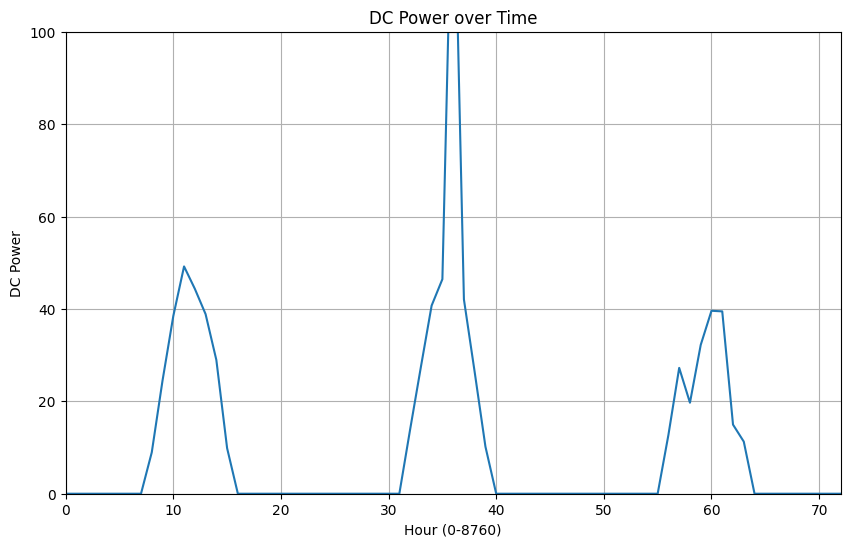

In [ ]:
# prompt: ploter la puissance dc avec les heures du fichier de 0à 8760 en bascisse


# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(range(len(dc_power_s4)), dc_power_s90['p_mp'])
plt.xlabel('Hour (0-8760)')
plt.ylabel('DC Power')
plt.title('DC Power over Time')
plt.grid(True)  # Add grid for better readability
plt.xlim(0,24*3) # Set x-axis limits
plt.ylim(0,100) # Set x-axis limits

#plt.show()

<ipython-input-12-989e6ecea82e>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  available_power[i] = dc_power_s0['p_mp'][i] + available_power[i-1]


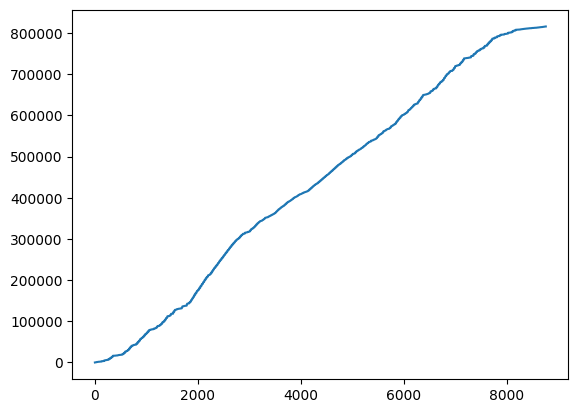

In [ ]:
hours_in_year = 24 * 365

available_power = [0.0] * hours_in_year

for i in range(hours_in_year):
    available_power[i] = dc_power_s0['p_mp'][i] + available_power[i-1]

# Convert the list to a pandas Series
available_power_series = pd.Series(available_power)


available_power_series_time = available_power_series.iloc[:8760]
# Plot the selected data
available_power_series_time.plot()
plt.show()

<Axes: xlabel='AAAAMMJJ'>

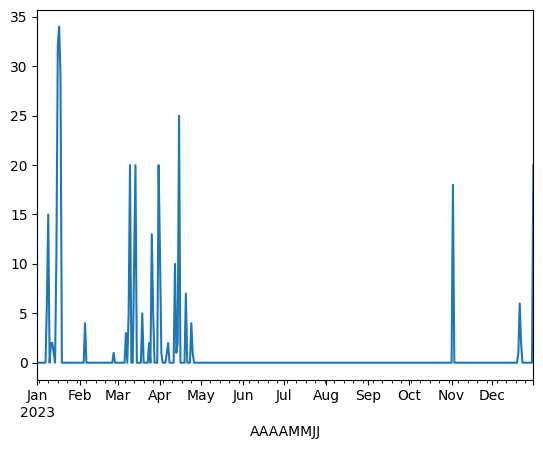

In [ ]:
url="https://raw.githubusercontent.com/apct69/Proj_Data/refs/heads/main/Fresh_Snow_Flaine_23.csv"
snow_data_flaine_23 = pd.read_csv(url, index_col=0,  header=0,sep=';')

# Assuming snow_data_flaine_23 is your DataFrame
snow_data_flaine_23.index = pd.to_datetime(snow_data_flaine_23['AAAAMMJJ'], format='%Y%m%d')
# The format string '%Y%m%d' specifies the structure of your date strings (YYYYMMDD)
# Replace NaN values with 0
snow_data_flaine_23 = snow_data_flaine_23.fillna(0)
snow_data_flaine_23['HNEIGEF'].plot()

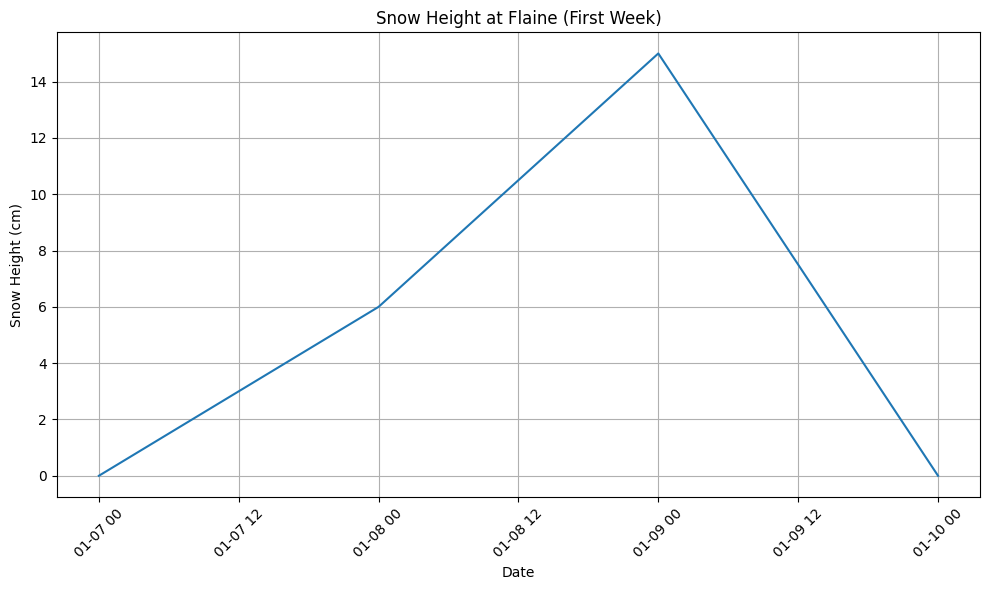

In [ ]:
# prompt: plot snow_data_flaine_23 for 1 week

# Assuming snow_data_flaine_23 is already loaded and processed as in your provided code.

# Select the first week of data
first_week_data = snow_data_flaine_23.iloc[round(150/24):round(250/24)]  # Assuming hourly data for a week (24 hours * 7 days = 168)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(first_week_data.index, first_week_data['HNEIGEF'])
plt.xlabel('Date')
plt.ylabel('Snow Height (cm)')
plt.title('Snow Height at Flaine (First Week)')
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
def exp_snow_loss(snow_height):

  #𝜌 is the snow density,
  #𝜌𝑖 is the ice density (= 917 kg m-3),
  #and 𝑟ef is the effective grain radius.
  #The values of the insolation extinction coefficient of different types of snow may range
  #from around 10 m-1 for soft new snow to 55 m-1 for hard powder snow [5].
  #The accumulation of ice also affects the incoming radiation with extinction coefficients ranging
  #from 2 m-1 for clear ice to 20 m-1 for cloudy ice.

  kext = 1/3 #(3*P)/(2*Pi *ref)  # Loss coefficient adjusted to obtain results from https://www.researchgate.net/publication/323058911_Modeling_of_Snow-Covered_Photovoltaic_Modules
  #S. Hosseini, S. Taheri, M. Farzaneh, and H. Taheri, “Modeling of Snow-Covered Photovoltaic Modules,” IEEE Trans. Ind. Electron., vol. 65, no. 10, pp. 7975–7983, Oct. 2018, doi: 10.1109/TIE.2018.2803725.
  snow_loss = (1-np.exp(-kext*snow_height))*100
  return snow_loss

i= 0 
 0.0
i= 1 
 28.34686894262107
i= 2 
 48.6582880967408
i= 3 
 63.212055882855765
i= 4 
 73.64028618842732
i= 5 
 81.11243971624381
i= 6 
 86.46647167633873
i= 7 
 90.30280321355949
i= 8 
 93.05165487771984
i= 9 
 95.0212931632136


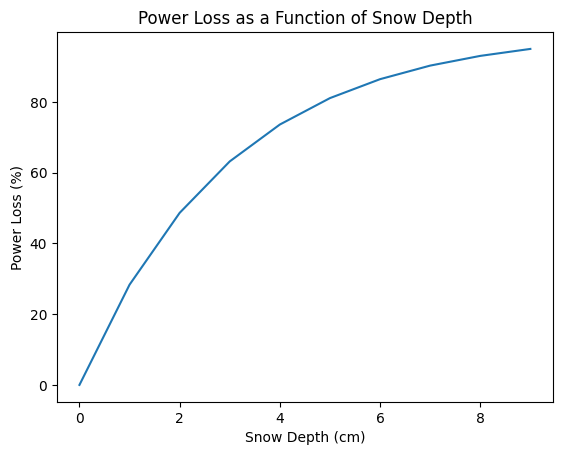

In [ ]:
snow_depth = 10
snow_loss = [0.0] * snow_depth

for i in range(snow_depth):
  snow_loss [i] = exp_snow_loss(i)
  print("i=", i,"\n",snow_loss[i])

# Convert the list to a pandas Series
snow_loss_series = pd.Series(snow_loss)

# Add labels and title to the plot
snow_loss_series.plot(xlabel='Snow Depth (cm)', ylabel='Power Loss (%)', title='Power Loss as a Function of Snow Depth')
plt.show()

Reproduction :
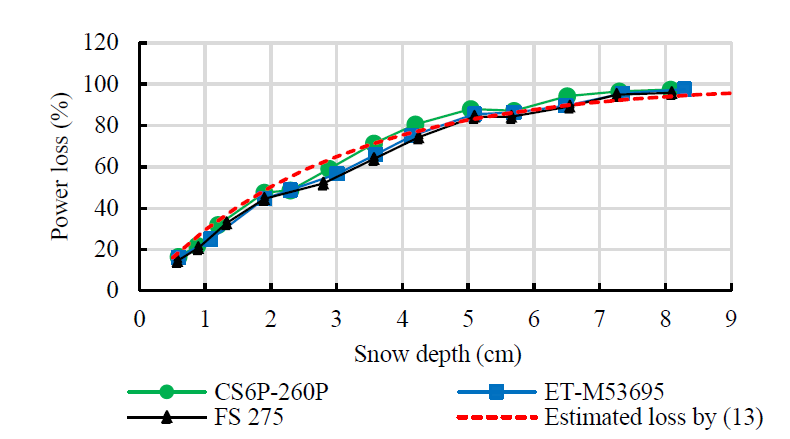

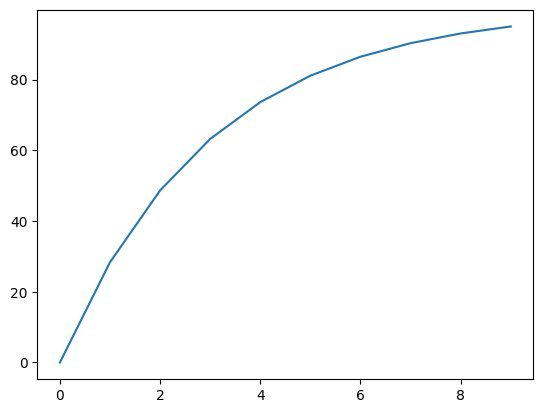

In [ ]:
# Convert the list to a pandas Series
snow_loss_series = pd.Series(snow_loss)

snow_loss_series.plot()
plt.show()

In [ ]:
# Create an empty DataFrame with the required columns
array_clean = pd.DataFrame(columns=['p_mp'])
array_clean['p_mp'] = dc_power_s0['p_mp'] + dc_power_s1['p_mp'] + dc_power_s2['p_mp'] + dc_power_s3['p_mp'] + dc_power_s4['p_mp']
array_snow = array_clean.copy()
array_snow['p_mp'] = 0

#for i in range(hours_in_year):
  # Use integer division to get the corresponding day index
  #snow_index = i // 24
  #array_snow['p_mp'].iloc[i] = dc_power_s0['p_mp'].iloc[i] + (dc_power_s1['p_mp'].iloc[i] + dc_power_s2['p_mp'].iloc[i] + dc_power_s3['p_mp'].iloc[i] + dc_power_s4['p_mp'].iloc[i]) * exp_snow_loss(snow_data_flaine_23['HNEIGEF'].iloc[snow_index])


(0.0, 8760.0)

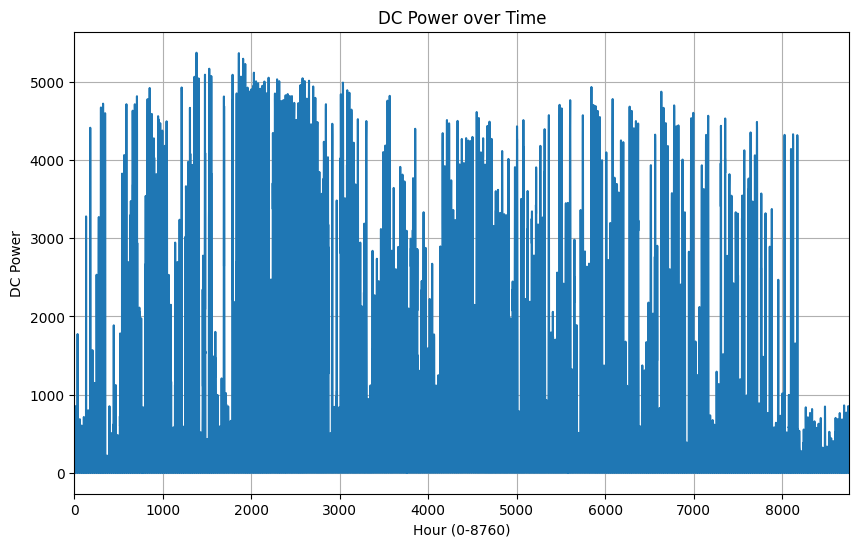

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(range(len(array_clean)), array_clean['p_mp'])
plt.xlabel('Hour (0-8760)')
plt.ylabel('DC Power')
plt.title('DC Power over Time')
plt.grid(True)  # Add grid for better readability
plt.xlim(0,24*365) # Set x-axis limits


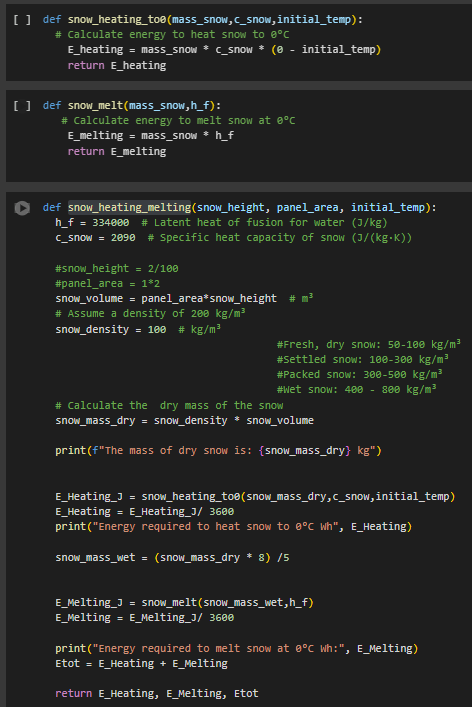

In [ ]:
# Instead of .iloc use .loc with the actual date index
day_index = snow_data_flaine_23.index[200//24] #Get the datetime object at position 8
print(snow_data_flaine_23.loc[day_index,'HNEIGEF'])
#or if you want the 8th row in the dataframe
print(snow_data_flaine_23['HNEIGEF'][200//24]) #Access it as a Series

15.0
15.0


<ipython-input-20-d57efc9b6340>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(snow_data_flaine_23['HNEIGEF'][200//24]) #Access it as a Series


In [ ]:
print(dc_power_s3['panel_area'][0])

6.59586


<ipython-input-21-3617e8572dcd>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(dc_power_s3['panel_area'][0])


In [ ]:
snow_removal_step = 0
available_energie = 0
needed_energie = 0
fresh_snow =0
snow_height_current=0
snow_loss = [0] * hours_in_year


for i in range(hours_in_year):
  print("hour:", i," | ",i%24,":00")
  snow_loss[i] = 0

  if snow_data_flaine_23['HNEIGEF'].iloc[i//24] > 0 and snow_data_flaine_23['HNEIGEF'].iloc[i//24] != snow_data_flaine_23['HNEIGEF'].iloc[(i-1)//24] and fresh_snow == 0:
    fresh_snow = 1
    snow_height_current += snow_data_flaine_23['HNEIGEF'].iloc[i//24]
    print("snow height:" ,snow_height_current)
  else: fresh_snow = 0

  if snow_height_current > 0:
    snow_loss[i] = 1
###########################################################
    match snow_removal_step:
      case 0:
        print("snow_removal_step 0")
        available_energie += dc_power_s0['p_mp'].iloc[i]
        needed_energie = snow_heating_melting(snow_height_current, dc_power_s1['panel_area'].iloc[0], weather.loc[weather.index[i], "temp_air"])

        if available_energie > needed_energie:
          snow_removal_step = 1
          available_energie= available_energie - needed_energie
          needed_energie = 0
        else:
          snow_removal_step = 0

      case 1:
        print("snow_removal_step 1")
        available_energie += dc_power_s0['p_mp'].iloc[i] + dc_power_s1['p_mp'].iloc[i]
        needed_energie = snow_heating_melting(snow_height_current, dc_power_s2['panel_area'].iloc[0], weather.loc[weather.index[i], "temp_air"])
        if available_energie > needed_energie:
          snow_removal_step = 2
          available_energie = available_energie - needed_energie
          needed_energie = 0
        else:
          snow_removal_step = 1

      case 2:
        print("snow_removal_step 2")
        available_energie += dc_power_s0['p_mp'].iloc[i] + dc_power_s1['p_mp'].iloc[i] + dc_power_s2['p_mp'].iloc[i]
        needed_energie = snow_heating_melting(snow_height_current, dc_power_s3['panel_area'].iloc[0], weather.loc[weather.index[i], "temp_air"])
        if available_energie > needed_energie:
          snow_removal_step = 3
          available_energie = available_energie - needed_energie
          needed_energie = 0
        else:
          snow_removal_step = 2

      case 3:
        print("snow_removal_step 3")
        available_energie += dc_power_s0['p_mp'].iloc[i] + dc_power_s1['p_mp'].iloc[i] + dc_power_s2['p_mp'].iloc[i] + dc_power_s3['p_mp'].iloc[i]
        needed_energie = snow_heating_melting(snow_height_current, dc_power_s4['panel_area'].iloc[0], weather.loc[weather.index[i], "temp_air"])
        if available_energie > needed_energie:
          snow_removal_step = 4
          available_energie = available_energie - needed_energie
          needed_energie = 0
        else:
          snow_removal_step = 4

      case 4:
        print("snow removed")
        snow_height_current = 0
        snow_removal_step = 0
        available_energie = 0

      case _:  # Default case (optional)
        print("Error Case")
###########################################################
  #else :

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
hour: 3960  |  0 :00
hour: 3961  |  1 :00
hour: 3962  |  2 :00
hour: 3963  |  3 :00
hour: 3964  |  4 :00
hour: 3965  |  5 :00
hour: 3966  |  6 :00
hour: 3967  |  7 :00
hour: 3968  |  8 :00
hour: 3969  |  9 :00
hour: 3970  |  10 :00
hour: 3971  |  11 :00
hour: 3972  |  12 :00
hour: 3973  |  13 :00
hour: 3974  |  14 :00
hour: 3975  |  15 :00
hour: 3976  |  16 :00
hour: 3977  |  17 :00
hour: 3978  |  18 :00
hour: 3979  |  19 :00
hour: 3980  |  20 :00
hour: 3981  |  21 :00
hour: 3982  |  22 :00
hour: 3983  |  23 :00
hour: 3984  |  0 :00
hour: 3985  |  1 :00
hour: 3986  |  2 :00
hour: 3987  |  3 :00
hour: 3988  |  4 :00
hour: 3989  |  5 :00
hour: 3990  |  6 :00
hour: 3991  |  7 :00
hour: 3992  |  8 :00
hour: 3993  |  9 :00
hour: 3994  |  10 :00
hour: 3995  |  11 :00
hour: 3996  |  12 :00
hour: 3997  |  13 :00
hour: 3998  |  14 :00
hour: 3999  |  15 :00
hour: 4000  |  16 :00
hour: 4001  |  17 :00
hour: 4002  |  18 

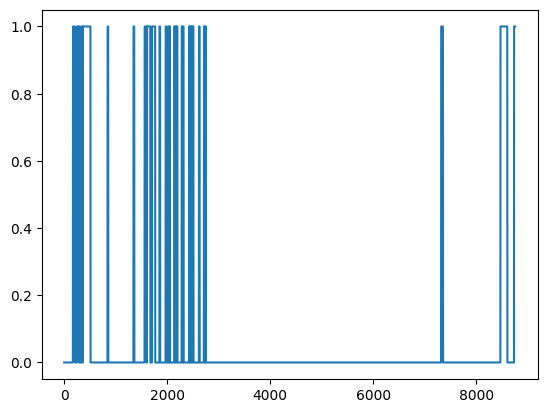

In [ ]:
# Convert the list to a pandas Series
snow_loss_series = pd.Series(snow_loss)

# Now you can plot
snow_loss_series.plot()
plt.show()

In [ ]:
# Calculate total power output
output_power_s0 = mc.results.ac * 2  # Power from 2 panels of system_s0
output_power_s1 = mc2.results.ac * 10 # Power from 10 panels of system_s1
total_output_power = output_power_s0 + output_power_s1
total_output_power_snow = total_output_power.copy()


In [ ]:
for i in range(hours_in_year):
  if snow_loss_series[i] == 1:
    total_output_power_snow.iloc[i] = 0

In [ ]:
total_output_power.index = pd.date_range(start='2023-01-01', periods=len(total_output_power), freq='h')
total_output_power_snow.index = pd.date_range(start='2023-01-01', periods=len(total_output_power_snow), freq='h')

In [ ]:
# Assuming 'snow_data_flaine_23' is your DataFrame with a DatetimeIndex
# and 'HNEIGEF' column containing the daily snow data

# Create a new DatetimeIndex with 5-minute intervals for the entire year
hourly_index = pd.date_range(start='2023-01-01', end='2023-12-31 23:00:00', freq='h')
snow_data_hourly = pd.DataFrame(index=hourly_index)
snow_data_hourly['HNEIGEF'] = 0

for i in range(len(hourly_index)):
  if i % 24 == 6 :
    snow_data_hourly['HNEIGEF'].iloc[i] = snow_data_flaine_23['HNEIGEF'].iloc[i//24]

<ipython-input-27-57ba8e8f9575>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  snow_data_hourly['HNEIGEF'].iloc[i] = snow_data_flaine_23['HNEIGEF'].iloc[i//24]


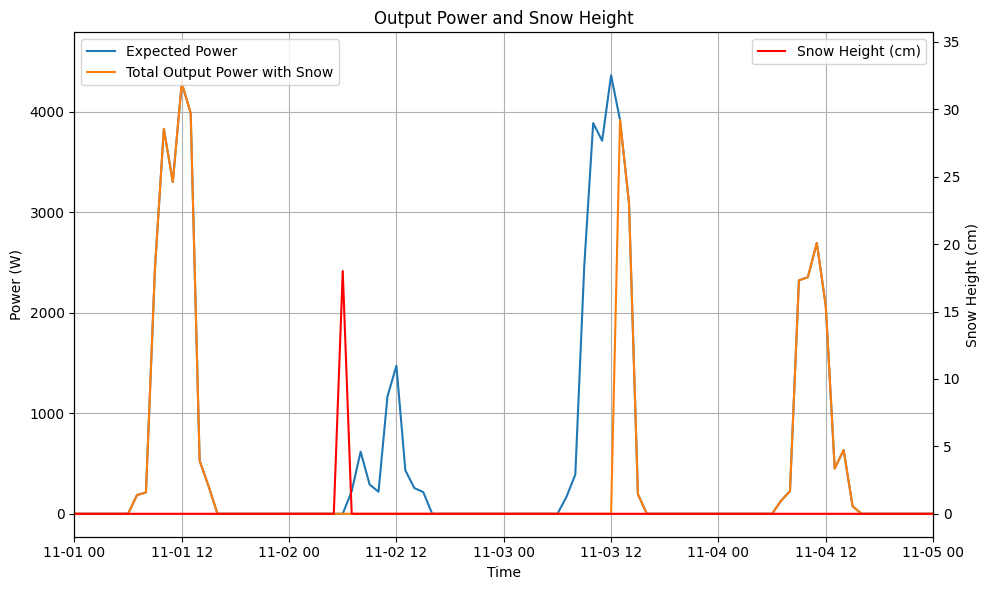

In [ ]:
# Create the figure and the first axes (for power)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total_output_power and total_output_power_snow on the first axes
ax1.plot(total_output_power.index, total_output_power, label='Expected Power')
ax1.plot(total_output_power_snow.index, total_output_power_snow, label='Total Output Power with Snow')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (W)')
ax1.grid(True)


# Create the second axes (for snow) sharing the same x-axis
ax2 = ax1.twinx()

# Plot snow_data_hourly on the second axes
ax2.plot(snow_data_hourly.index, snow_data_hourly, label='Snow Height (cm)', color='red')  # Use a different color for snow
ax2.set_ylabel('Snow Height (cm)')

# Add legends to both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xlim(pd.Timestamp('2023-11-01'), pd.Timestamp('2023-11-05'))
#plt.ylim(0,100) # Set x-axis limits
plt.title('Output Power and Snow Height')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
print(total_output_power.sum())
print(total_output_power_snow.sum())

print(total_output_power_snow.sum()/total_output_power.sum()
)

6521680.221095917
5958418.419972771
0.9136324103562848
